# Building an Image Classifier

Today we are going to implement a simple neural network in order to classify and distinguish between handwritten digits. In other words, we are implementing an image classifier. The total structure of the classifier that we are going to build is shown in the following image. As simple as that!

We will use MNIST, a very famouse dataset which contains 55000 images of digits with their labels for training and also, 10,000 more images for testing. At the end, our simple classifier will be able to classify images with the accuracy of around 92%!

I will show you and explain to you step by step what we are going to do and the reason behind that. You can press the Run button to run each step and move on to the next one. If you are courious and when it is possible, you can change some values to see their effect on the performance and running time (values of the variables that have CAPITAL names). Codes are written for Python 3, with the assumption that you already have installed Tensorflow on your computer. 

What we are doing today is based on a tutorial presented on the Tensorflow's webpage:
https://www.tensorflow.org/versions/r1.0/get_started/mnist/beginners

I also used some of the helpful functions that were written on this very interesting blog post by Justin Francis:
https://www.oreilly.com/learning/not-another-mnist-tutorial-with-tensorflow


<img src="Images/Total_Network.png">

## Loading Libraries

Before anything, let's bring some libraries that we need for plotting the results and of course for calculating them.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Loading MNIST Dataset

Our goal for today is to create a neural network image classifier that is capable of classifying handwritten digits. So the first step would be to have a dataset of handwritten digits. MNIST is a very famous dataset that contains more than 60K images along with their labels. They divided the images into two parts, 55,000 images for training and 10,000 images for testing the performance of the classifier. Each image is labeled by a person and that's our ground truth. All the labels are also included in the dataset. Images are 28\*28 pixels.

<img src="Images/mnist_plot-800x600.png">

Let's load the MNIST dataset.
This may take a while especially the first time since it has to download the Dataset from the internet first. You will see some warnings that you can ignore...

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Defining some functions for displaying the digits and flattening them

We need to define some simple functions for flattening and displaying the data. 

The function display_digit() will pick a random image from the MNIST Train dataset and will show it along with it's label.

The function display_mult_flat(batch_size) will pick a random subset of images from the MNIST Train dataset, with the size of batch_size. It will then flatten each 28\*28 image to a 1\*784 wide image and show all of them at once. More details about image flattening will be explained later.

In [3]:
def display_digit():
    x_train, y_train = mnist.train.next_batch(1)
    print(y_train)
    label = y_train.argmax(axis=1)
    image = x_train.reshape([28,28])
    plt.title('Example Label: ' +  str(label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()

def display_mult_flat(batch_size):
    x_train, y_train = mnist.train.next_batch(batch_size)
    images = x_train[0].reshape([1,784])
    for i in range(1, batch_size):
        images = np.concatenate((images, x_train[i].reshape([1,784])))
    plt.imshow(images, cmap=plt.get_cmap('gray_r'))
    plt.show()

Let's see a random image from the MNIST Train Folder and its label...

The labe is in the hot-vector format, which means since each digit can be between 0-9, each lable is a list with the length of 10, all members are zero except the one representing the true number. 

For example, if the image is showing a '9', its label will be: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], and if the image is showing a '3', its label will be: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


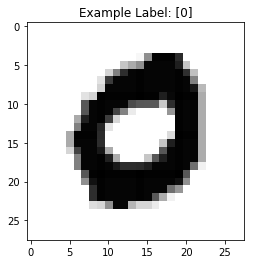

In [4]:
display_digit()

## Training a Neural Network Model

Here is how a neural network model will be trained in layman terms. We show the model a bunch of images, it will make some random guesses the first time and produce some results (that will probably be garbage). It will then compare the results with the ground truth labels of those images and realize how bad the results are. It will then modify itself in a way to have a better guesses next time. We then show it another bunch of images. The model will guess some results, but since it already has seen some images, this time it will have a better guess. Then again, it will compare its results with the labels. It will continue this cycle for a while, or until its performance would not change anymore.

Training a neural network model is like showing someone who does not know about Marvel superheroes a collection of superhero images. At first, the guy does not know the name of superheroes, and his guesses can be completely irrelavant.



<img src="Images/First_Guess.PNG">

Then we show hime where he is wrong and what is their right names. Then he would say that he understood, but probably not entirely... Next time we show him some new images and he will guess the names again.

<img src="Images/Second_Guess.PNG">

Not bad, he got some names right. But there is still room for improvement. We let him know where he was wrong and what is the right name. Then again, we will test him with more images of superheroes...

<img src="Images/Third_Guess.PNG">

Finally! He got them all right :)

That's exactly how the training works. We will give it random image batches several times and everytime it will improve its results.

## Image Flatenning

Now that we have MNIST images ready, we can give them to the model as input. Each image is gray (not RGB) with the width and height of 28\*28. Each pixel values is in range of [0, 255] where 0 means black and 255 means white. We need to make each image flat in order to feed it to the neural network. Therefore by flattening each image, we will have a vector with size of 1\*784.


<img src="Images/Image_Flattening.png">

Every time we feed the model with several image altogether. We call this package of images a batch. 
In the following piece of code, you can see a picture of a batch of random flatted images. We have 784 columns and each row represents one image. You can change the batch size (number of rows) to see how it changes the picture.

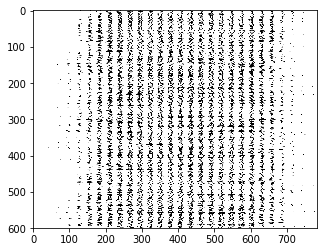

In [5]:
BATCH_SIZE = 600
display_mult_flat(BATCH_SIZE)

## Construct the model with Tensorflow

After loading the MNIST images and now that we figured out how we want to feed the images to the model, now it is time to construct the actual neural network model. In order to do that we need to work with Google Tensorflow. Tensorflow is an application for working with graphes, i.e. nodes and edges. Let's load the Tensorflow and start it.


In [6]:
import tensorflow as tf
sess = tf.Session()

The model that we have in mind is very simple and you can see its design in the following picture. 
Assuming that we want to feed only one image to the model for now, the input of our model contains 784 nodes, each representing one pixel of the image, and the output has 10 nodes, representing 10 digits. Input nodes are shown with green color and output nodes are shown with red. I will talk about the blue nodes later. Each red node represents one number. Based on the values of the green nodes, each red node will have a different score/value. For each image, we want its represented node to have the highest score among the others. For example, if the image represents an '8' we would like the ninth node to have the highest score (first node is the representative of number zero).

Score of each red node will be calculated based on the effect of each pixel. For each red node, we want pixels (green nodes) that show the number in the input image to be more important and have higher effect. This way, the score of that node will be higher. This can be done by using the yellow weigths. As you can see, W is a table of 784\*10 and each member of this matrix represnets the importance of that pixel to that number final result. For example, the value in row 12 and column 5 shows us how much the 12th pixels is important in recognizing images of number 4 (first red node represents number zero).

In addition to the the effect of each pixel on the digit recognition, we also want to add some independency from the pixel values to the score calculation. That can be done by adding a separate constant number to each red nodes calculation.

Therefore, for each red node, the score will be calculated by the following equation:
<img src="Images/Score_Calculation.PNG">



<img src="Images/Model_Details_1.PNG">

We define X and Y_ as placeholders as they are the only thing we have now and we will get from the MNIST dataset...

When we assign None to our placeholder, it means the placeholder can be fed as many examples as you want to give it. In this case, our placeholder can be fed any multitude of 784-sized values.

We then define y_, which will be used to feed y_train into. This will be used later so we can compare the ground truths to our predictions. We can also think of our labels as classes:

In [7]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Next, we will define the weights W and bias b. These two values are the only values we will need to optimize to calculate our prediction after the classifier is trained.

We will first set our weight and bias values to zeros because TensorFlow will optimize these values later. Notice how our W is a collection of 784 values for each of the 10 classes:

In [8]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

And we define score vector S as:

In [9]:
S = tf.matmul(x,W) + b

## Softmax Function

The next part is about softmax and I should write a introduction here...

<img src="Images/Model_Details_2.PNG">

In [10]:
y = tf.nn.softmax(S)

In [28]:
BATCH_SIZE = 7
x_train, y_train = mnist.train.next_batch(BATCH_SIZE)
sess.run(tf.global_variables_initializer())
print(sess.run(y, feed_dict={x: x_train}))

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


In [29]:
test_result_1 = tf.nn.softmax(tf.zeros([4]))
sess.run(test_result_1)

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [30]:
test_result_2 = tf.nn.softmax(tf.constant([0.1, 0.005, 2, 0.1, 0.005, 2, 0.1, 0.005, 2, 0.3]))
sess.run(test_result_2)

array([0.03702715, 0.03367149, 0.24755964, 0.03702715, 0.03367149,
       0.24755964, 0.03702715, 0.03367149, 0.24755964, 0.04522507],
      dtype=float32)

## Comparing the results with ground truth labels

<img src="Images/Comparing_Results.PNG">

## Loss function (Cross Entropy)
Next, we will create our cross_entropy function, also known as a loss or cost function. It measures how good (or bad) of a job we are doing at classifying. The higher the cost, the higher the level of inaccuracy. It calculates accuracy by comparing the true values from y_train to the results of our prediction y for each example. The goal is to minimize your loss:

In [31]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [32]:
predicted_result = [0.03, 0.03, 0.01, 0.9, 0.01, 0.01, 0.0025,0.0025, 0.0025, 0.0025]

In [33]:
test_label_1 = [0,0,0,1,0,0,0,0,0,0]
test_label_2 = [0,0,0,0,0,0,0,0,0,1]

In [34]:
cross_entropy_1 = np.sum(-np.multiply(test_label_1, np.log(predicted_result)))
cross_entropy_2 = np.sum(-np.multiply(test_label_2, np.log(predicted_result)))

In [35]:
print('cross_entropy_1 (correct prediction): ' + str(cross_entropy_1))
print('cross_entropy_2 (wrong prediction): ' + str(cross_entropy_2))

cross_entropy_1 (correct prediction): 0.10536051565782628
cross_entropy_2 (wrong prediction): 5.991464547107982


We can now initialize all variables so that they can be used by our TensorFlow graph:

We can now initialize the TensorFlow graph:

In [37]:
TRAIN_STEPS = 2500
TRAIN_BATCH_SIZE = 200
TEST_BATCH_SIZE = 2000
LEARNING_RATE = 0.1

training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()
sess.run(init)
weight = sess.run(W)
W_List = [weight]
for i in range(TRAIN_STEPS+1):
    x_train, y_train = mnist.train.next_batch(TRAIN_BATCH_SIZE)
    sess.run(training, feed_dict={x: x_train, y_: y_train})
    if i%100 == 0:
        x_test, y_test = mnist.test.next_batch(TEST_BATCH_SIZE)
        print('Training Step:' + str(i) + '  Accuracy =  ' + str(sess.run(accuracy, feed_dict={x: x_test, y_: y_test})) + '  Loss = ' + str(sess.run(cross_entropy, {x: x_train, y_: y_train})))
        weight = sess.run(W)
        W_List.append(weight)

Training Step:0  Accuracy =  0.3735  Loss = 2.1618845
Training Step:100  Accuracy =  0.8685  Loss = 0.62677
Training Step:200  Accuracy =  0.874  Loss = 0.5736895
Training Step:300  Accuracy =  0.8945  Loss = 0.43702927
Training Step:400  Accuracy =  0.907  Loss = 0.501717
Training Step:500  Accuracy =  0.9015  Loss = 0.43819782
Training Step:600  Accuracy =  0.8945  Loss = 0.4419573
Training Step:700  Accuracy =  0.905  Loss = 0.2977523
Training Step:800  Accuracy =  0.909  Loss = 0.2652193
Training Step:900  Accuracy =  0.9055  Loss = 0.4507031
Training Step:1000  Accuracy =  0.908  Loss = 0.35138604
Training Step:1100  Accuracy =  0.907  Loss = 0.34252247
Training Step:1200  Accuracy =  0.9185  Loss = 0.2933004
Training Step:1300  Accuracy =  0.916  Loss = 0.36384827
Training Step:1400  Accuracy =  0.911  Loss = 0.3074393
Training Step:1500  Accuracy =  0.9175  Loss = 0.35592148
Training Step:1600  Accuracy =  0.9155  Loss = 0.2799958
Training Step:1700  Accuracy =  0.916  Loss = 0.

Now let's see the weights evolution

In [48]:
def showTheWeights(number_of_iterations, W_List):
    w=28
    h=28
    fig=plt.figure(figsize=(28, 28))
    columns = 10
    rows = NUMBER_OF_ITERATIONS
    for row_index in range(number_of_iterations):
        temp_W = W_List[row_index]
        for col_index in range (10):
            weight = temp_W[:,col_index]
            img = weight.reshape([28,28])
            i = 10*row_index + col_index + 1
            fig.add_subplot(rows, columns, i)
            plt.imshow(img, cmap=plt.get_cmap('seismic'))
    plt.show()

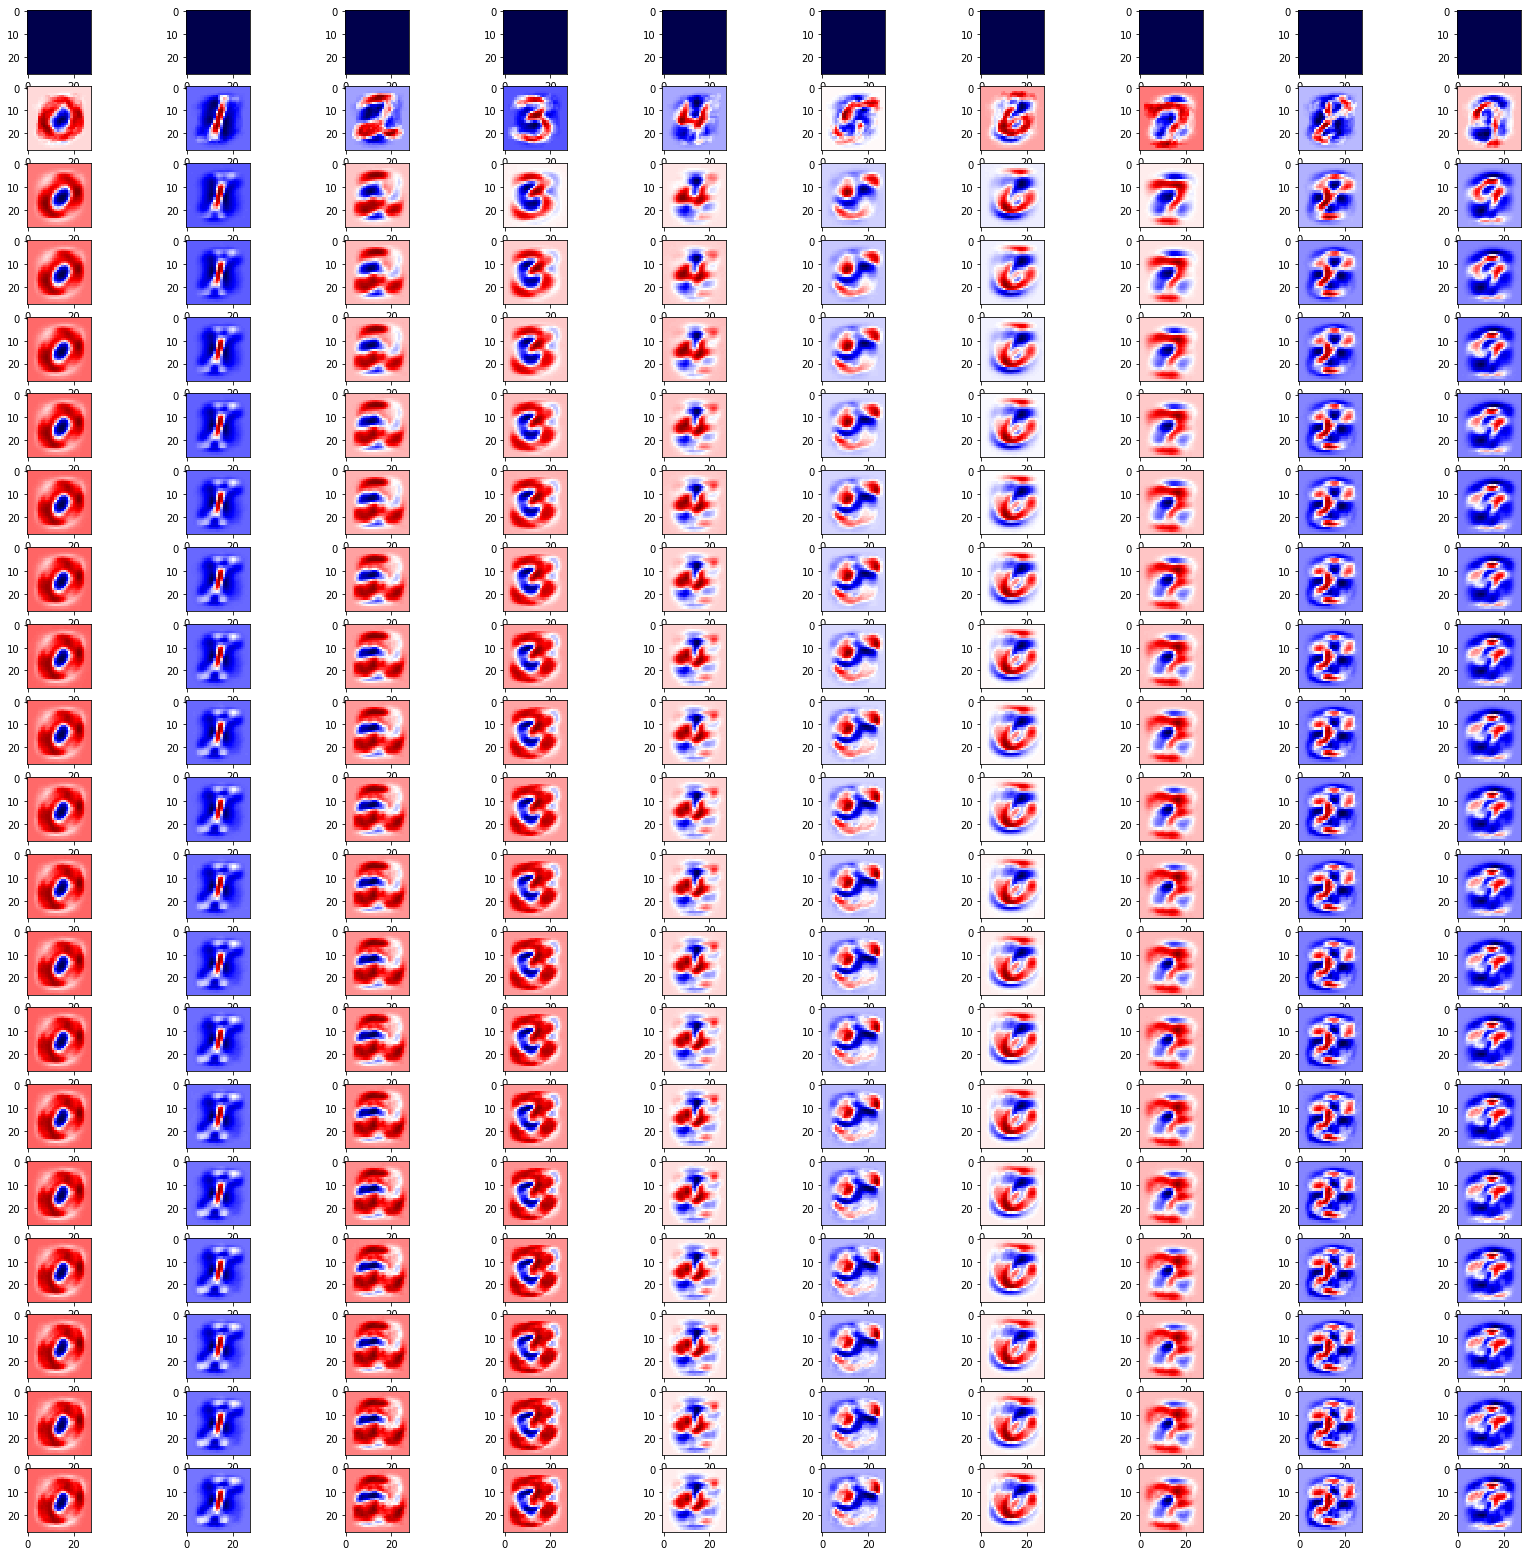

In [49]:
NUMBER_OF_ITERATIONS = 20
showTheWeights(NUMBER_OF_ITERATIONS, W_List)

Now, let's try it on some new random images from the test dataset:

In [50]:
resultTable = tf.placeholder(tf.float32, shape=[None, 10])
final_result = tf.argmax(resultTable,1)
def readable_results(rawTable):
    return(sess.run(final_result, feed_dict={resultTable: rawTable}))
    

def display_wrong_digits(x_test, predicted, true_label):
    wrong_detected_indices = (np.where(predicted!=true_label))[0]
    if (len(wrong_detected_indices)>0):
        for index in wrong_detected_indices:
            image = x_test[index].reshape(28,28)
            result = predicted[index]
            label = true_label[index]
            plt.title('Example Label: ' +  str(label) + ', predicted as: ' + str(result))
            plt.imshow(image, cmap=plt.get_cmap('gray_r'))
            plt.show()
            
    else:
        print('All the images are detected correctly.')
   

Predicted:  [2 8 2 0 8 9 9 5 2 5 7 7 2 9 4 4 3 2 3 6 6 3 2 1 6 3 6 7 0 2]
True Label: [2 8 2 0 8 9 4 5 2 6 7 7 2 4 4 4 3 7 3 6 6 3 2 1 6 3 6 7 0 2]


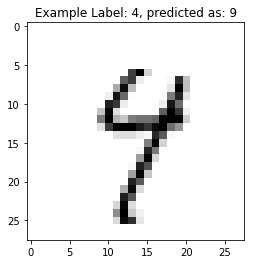

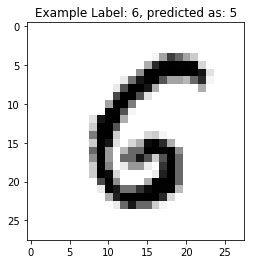

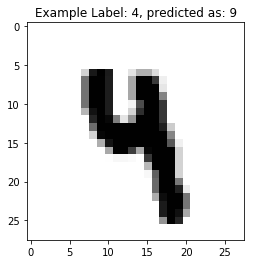

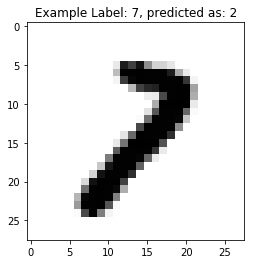

In [59]:
FINAL_TEST_BATCH_SIZE = 30
x_test, y_test = mnist.test.next_batch(FINAL_TEST_BATCH_SIZE)

### EQUATION: y = tf.nn.softmax(tf.matmul(x,W) + b) ###
predicted_values = sess.run(y, feed_dict={x: x_test})


predicted = readable_results(predicted_values)
true_label = readable_results(y_test)
print('Predicted:  ' + ''.join(str(predicted)))
print('True Label: ' + ''.join(str(true_label)))

display_wrong_digits(x_test, predicted, true_label)

## Sometimes it is hard to tell...
<img src="Images/Superhero_Confused.PNG">


# And the whole code again:

In [56]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import tensorflow as tf
sess = tf.Session()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

S = tf.matmul(x,W) + b

y = tf.nn.softmax(S)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

LEARNING_RATE = 0.1
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

TRAIN_STEPS = 2500
TRAIN_BATCH_SIZE = 200
TEST_BATCH_SIZE = 2000


init = tf.global_variables_initializer()
sess.run(init)

for i in range(TRAIN_STEPS+1):
    x_train, y_train = mnist.train.next_batch(TRAIN_BATCH_SIZE)
    sess.run(training, feed_dict={x: x_train, y_: y_train})
    if i%100 == 0:
        x_test, y_test = mnist.test.next_batch(TEST_BATCH_SIZE)
        print('Training Step:' + str(i) + '  Accuracy =  ' + str(sess.run(accuracy, feed_dict={x: x_test, y_: y_test})) + '  Loss = ' + str(sess.run(cross_entropy, {x: x_train, y_: y_train})))


print('\n\n Now, the network is trained which means weights (W and b) are optimized...')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Training Step:0  Accuracy =  0.449  Loss = 2.1572328
Training Step:100  Accuracy =  0.868  Loss = 0.59456515
Training Step:200  Accuracy =  0.8865  Loss = 0.5141357
Training Step:300  Accuracy =  0.886  Loss = 0.41251478
Training Step:400  Accuracy =  0.8995  Loss = 0.46411115
Training Step:500  Accuracy =  0.9035  Loss = 0.38167727
Training Step:600  Accuracy =  0.9165  Loss = 0.41936016
Training Step:700  Accuracy =  0.9005  Loss = 0.41822067
Training Step:800  Accuracy =  0.8975  Loss = 0.3319767
Training Step:900  Accuracy =  0.91  Loss = 0.3113437
Training Step:1000  Accuracy =  0.92  Loss = 0.37430638
Training Step:1100  Accuracy =  0.9155  Loss = 0.3770787
Training Step:1200  Accuracy =  0.912  Loss = 0.4058119
Training Step:1300  Accuracy =  0.909  Loss = 0.30506036
Training Step:1400  A